In [ ]:
pip install pandas geopandas folium rasterio shapely matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.5 MB/s eta 0:00:00


In [ ]:
!apt-get install -y poppler-utils
!pip install pdf2image


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (255 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123633 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
from pdf2image import convert_from_path
import os


In [ ]:
# Path to the PDF file (you can upload it or specify the path if it's in Google Drive)
pdf_path = '/content/your_pdf_file.pdf'

# Convert PDF to list of images
images = convert_from_path(pdf_path, dpi=300)  # dpi controls image quality

# Save each page as a TIF file
output_dir = '/content/tif_images/'
os.makedirs(output_dir, exist_ok=True)

# Loop over the images (one per page) and save as TIF
for i, image in enumerate(images):
    tif_path = os.path.join(output_dir, f'page_{i+1}.tif')
    image.save(tif_path, 'TIFF')

# Verify the TIF files were created
os.listdir(output_dir)


In [ ]:
!pip install Pillow


In [ ]:
from PIL import Image


In [ ]:
# Load the PNG image
png_path = '/content/tropical.png'  # Specify the path to your PNG file
tif_path = '/content/your_image.tif'# Specify the output path for the TIF file

# Open the PNG image using Pillow
img = Image.open(png_path)

# Save the image as TIFF
img.save(tif_path, 'TIFF')

# Verify the conversion
print(f"Image saved as: {tif_path}")


Image saved as: /content/your_image.tif


In [ ]:
# Load the PNG image
png_path = '/content/tropical2.png'  # Specify the path to your PNG file
tif_path = '/content/tropical2.tif'# Specify the output path for the TIF file

# Open the PNG image using Pillow
img = Image.open(png_path)

# Save the image as TIFF
img.save(tif_path, 'TIFF')

# Verify the conversion
print(f"Image saved as: {tif_path}")


Image saved as: /content/tropical2.tif


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 49.7 MB/s eta 0:00:00


In [ ]:
!pip install imagecodecs  # Install the required package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 16.0 MB/s eta 0:00:00


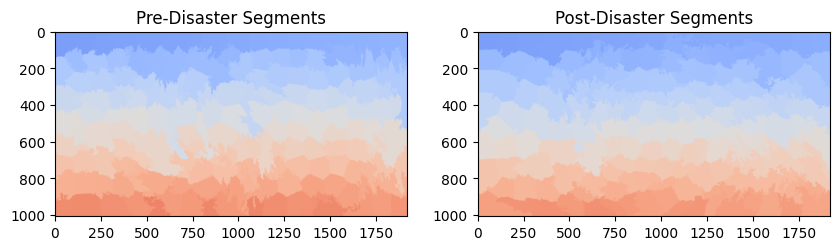

<Figure size 640x480 with 0 Axes>

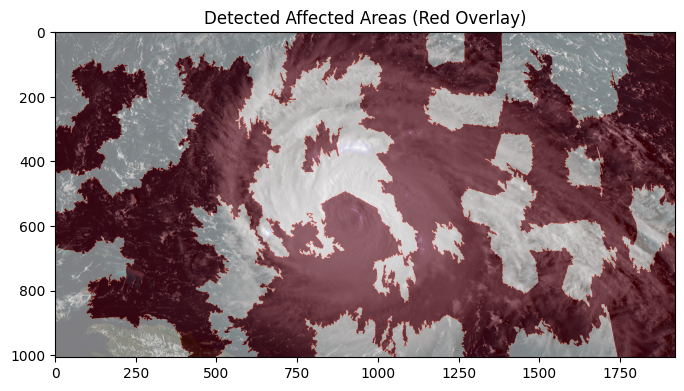

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import matplotlib.patches as mpatches

# Paths to your pre-disaster and post-disaster images (use your uploaded file paths in Colab)
pre_disaster_image = '/content/tropical 1 fin.tif'
post_disaster_image = '/content/tropical 2 fin.tif'

# Function to load an image
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # Read RGB channels
    return image

# Load images
pre_image = load_image(pre_disaster_image)
post_image = load_image(post_disaster_image)

# Step 2: Process the Data Collected (Normalize and Resize)
def normalize_image(image):
    image = image.astype('float32')
    return (image - image.min()) / (image.max() - image.min())

pre_image = normalize_image(pre_image)
post_image = normalize_image(post_image)

# Step 3: Segment Images into Meaningful Objects
# Using SLIC for segmentation
def segment_image(image, n_segments=200):
    segments = slic(image.transpose(1, 2, 0), n_segments=n_segments, compactness=10)
    return segments

pre_segments = segment_image(pre_image)
post_segments = segment_image(post_image)

# Step 4: Extract Object Features
# Here, we calculate average color and size per segment
def extract_features(image, segments):
    features = []
    labels = np.unique(segments)
    for label in labels:
        mask = segments == label
        mean_color = image[:, mask].mean(axis=1)
        size = mask.sum()
        features.append((mean_color, size))
    return features

pre_features = extract_features(pre_image, pre_segments)
post_features = extract_features(post_image, post_segments)

# Step 5: Generate Visual Maps
# Define a fixed colormap to assign a mix of light and slightly dark colors to corresponding segments
colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(np.unique(pre_segments))))  # Adjust range for lighter and darker colors
color_dict = {label: colors[i] for i, label in enumerate(np.unique(pre_segments))}

# Function to color segments consistently
def color_segments(segments, color_dict):
    color_image = np.zeros((segments.shape[0], segments.shape[1], 3))
    for label, color in color_dict.items():
        color_image[segments == label] = color[:3]  # Use only RGB values, not alpha
    return color_image

# Create colored segment images for pre- and post-disaster using the same light and dark colors
pre_segmented_colored = color_segments(pre_segments, color_dict)
post_segmented_colored = color_segments(post_segments, color_dict)

# Display the pre- and post-disaster segments with the same light and slightly dark colors
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(pre_segmented_colored)
plt.title("Pre-Disaster Segments")
plt.subplot(122)
plt.imshow(post_segmented_colored)
plt.title("Post-Disaster Segments")
plt.show()

# Step 6: Generate Simplified Legend for Important Segments (Optional)
legend_labels = {label: f"Segment {label}" for label in np.unique(pre_segments)}
legend_patches = [mpatches.Patch(color=color_dict[label], label=legend_labels[label]) for label in np.unique(pre_segments)]
plt.figlegend(handles=legend_patches, loc='lower center', ncol=5, title="Segment Legend")
plt.show()

# Step 7: Compute the Difference Map
# Difference map based on average color change (example for demonstration)
difference_map = np.zeros_like(pre_segments)
for i, (pre_feat, post_feat) in enumerate(zip(pre_features, post_features)):
    pre_color, pre_size = pre_feat
    post_color, post_size = post_feat
    diff = np.linalg.norm(pre_color - post_color)
    difference_map[pre_segments == i] = diff > 0.2  # Threshold for visual change

# Display the affected areas (using a red overlay for detected changes)
plt.figure(figsize=(8, 8))
plt.imshow(post_image.transpose(1, 2, 0))
plt.imshow(difference_map, cmap='Reds', alpha=0.5)
plt.title("Detected Affected Areas (Red Overlay)")
plt.show()


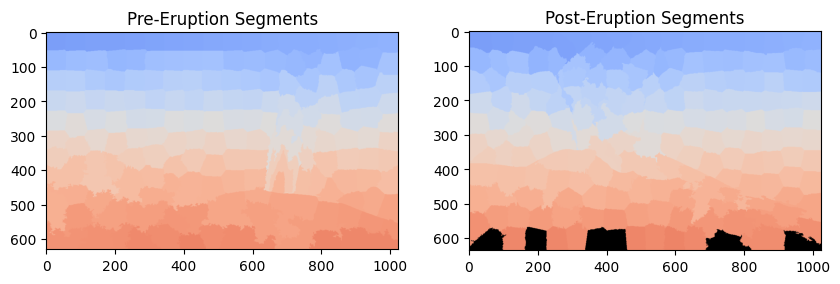

<Figure size 640x480 with 0 Axes>

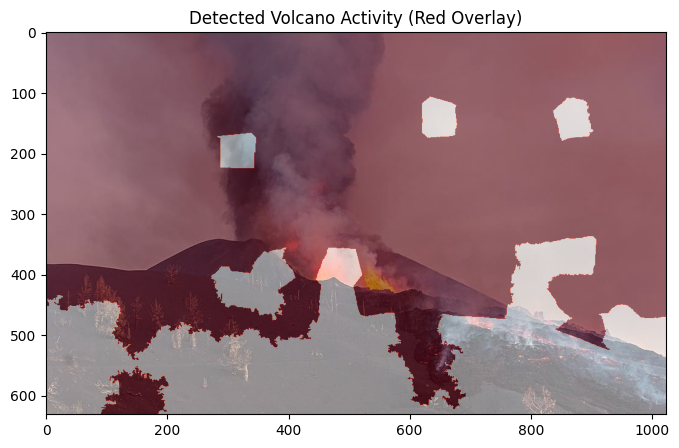

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import matplotlib.patches as mpatches

# Paths to your pre-eruption and post-eruption images (use your uploaded file paths in Colab)
pre_eruption_image = '/content/change in 1 volcano(1).tif'
post_eruption_image = '/content/final2 volcano.tif'

# Function to load an image
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # Read RGB channels
    return image

# Load images
pre_image = load_image(pre_eruption_image)
post_image = load_image(post_eruption_image)

# Step 2: Process the Data Collected (Normalize and Resize)
def normalize_image(image):
    image = image.astype('float32')
    return (image - image.min()) / (image.max() - image.min())

pre_image = normalize_image(pre_image)
post_image = normalize_image(post_image)

# Step 3: Segment Images into Meaningful Objects
# Using SLIC for segmentation
def segment_image(image, n_segments=200):
    segments = slic(image.transpose(1, 2, 0), n_segments=n_segments, compactness=10)
    return segments

pre_segments = segment_image(pre_image)
post_segments = segment_image(post_image)

# Step 4: Extract Object Features
# Here, we calculate average color and size per segment
def extract_features(image, segments):
    features = []
    labels = np.unique(segments)
    for label in labels:
        mask = segments == label
        mean_color = image[:, mask].mean(axis=1)
        size = mask.sum()
        features.append((mean_color, size))
    return features

pre_features = extract_features(pre_image, pre_segments)
post_features = extract_features(post_image, post_segments)

# Step 5: Generate Visual Maps
# Use a colormap that generates light and slightly darker colors (Pastel1 or coolwarm)
colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(np.unique(pre_segments))))  # Adjust the colormap range
color_dict = {label: colors[i] for i, label in enumerate(np.unique(pre_segments))}

# Function to color segments consistently
def color_segments(segments, color_dict):
    color_image = np.zeros((segments.shape[0], segments.shape[1], 3))
    for label, color in color_dict.items():
        color_image[segments == label] = color[:3]  # Use only RGB values, not alpha
    return color_image

# Create colored segment images for pre- and post-eruption using the same colors
pre_segmented_colored = color_segments(pre_segments, color_dict)
post_segmented_colored = color_segments(post_segments, color_dict)

# Display the pre- and post-eruption segments with the same colors
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(pre_segmented_colored)
plt.title("Pre-Eruption Segments")
plt.subplot(122)
plt.imshow(post_segmented_colored)
plt.title("Post-Eruption Segments")
plt.show()

# Step 6: Generate Simplified Legend for Important Segments (Optional)
legend_labels = {label: f"Volcano Activity {label}" for label in np.unique(pre_segments)}
legend_patches = [mpatches.Patch(color=color_dict[label], label=legend_labels[label]) for label in np.unique(pre_segments)]
plt.figlegend(handles=legend_patches, loc='lower center', ncol=5, title="Volcano Activity Legend")
plt.show()

# Step 7: Compute the Difference Map
# Difference map based on average color change (example for demonstration)
difference_map = np.zeros_like(pre_segments)
for i, (pre_feat, post_feat) in enumerate(zip(pre_features, post_features)):
    pre_color, pre_size = pre_feat
    post_color, post_size = post_feat
    diff = np.linalg.norm(pre_color - post_color)
    difference_map[pre_segments == i] = diff > 0.2  # Threshold for visual change

# Display the affected areas (using a red overlay for detected changes)
plt.figure(figsize=(8, 8))
plt.imshow(post_image.transpose(1, 2, 0))
plt.imshow(difference_map, cmap='Reds', alpha=0.5)
plt.title("Detected Volcano Activity (Red Overlay)")
plt.show()


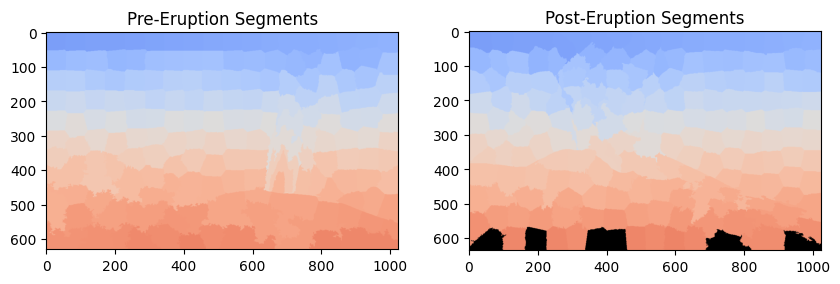

<Figure size 640x480 with 0 Axes>

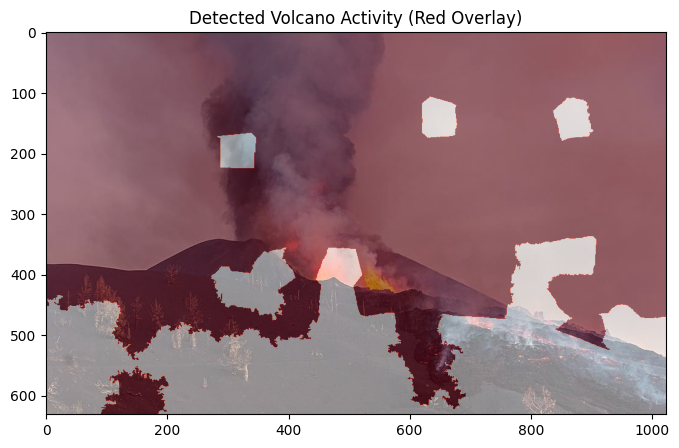

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import matplotlib.patches as mpatches

# Paths to your pre-eruption and post-eruption images (use your uploaded file paths in Colab)
before_image_path = '/content/uint16_before_image.tif'  # uint16 format
after_image_path = '/content/float32_after_image.tif'  # float32 format


# Function to load an image
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # Read RGB channels
    return image

# Load images
pre_image = load_image(pre_eruption_image)
post_image = load_image(post_eruption_image)

# Step 2: Process the Data Collected (Normalize and Resize)
def normalize_image(image):
    image = image.astype('float32')
    return (image - image.min()) / (image.max() - image.min())

pre_image = normalize_image(pre_image)
post_image = normalize_image(post_image)

# Step 3: Segment Images into Meaningful Objects
# Using SLIC for segmentation
def segment_image(image, n_segments=200):
    segments = slic(image.transpose(1, 2, 0), n_segments=n_segments, compactness=10)
    return segments

pre_segments = segment_image(pre_image)
post_segments = segment_image(post_image)

# Step 4: Extract Object Features
# Here, we calculate average color and size per segment
def extract_features(image, segments):
    features = []
    labels = np.unique(segments)
    for label in labels:
        mask = segments == label
        mean_color = image[:, mask].mean(axis=1)
        size = mask.sum()
        features.append((mean_color, size))
    return features

pre_features = extract_features(pre_image, pre_segments)
post_features = extract_features(post_image, post_segments)

# Step 5: Generate Visual Maps
# Use a colormap that generates light and slightly darker colors (Pastel1 or coolwarm)
colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(np.unique(pre_segments))))  # Adjust the colormap range
color_dict = {label: colors[i] for i, label in enumerate(np.unique(pre_segments))}

# Function to color segments consistently
def color_segments(segments, color_dict):
    color_image = np.zeros((segments.shape[0], segments.shape[1], 3))
    for label, color in color_dict.items():
        color_image[segments == label] = color[:3]  # Use only RGB values, not alpha
    return color_image

# Create colored segment images for pre- and post-eruption using the same colors
pre_segmented_colored = color_segments(pre_segments, color_dict)
post_segmented_colored = color_segments(post_segments, color_dict)

# Display the pre- and post-eruption segments with the same colors
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(pre_segmented_colored)
plt.title("Pre-Eruption Segments")
plt.subplot(122)
plt.imshow(post_segmented_colored)
plt.title("Post-Eruption Segments")
plt.show()

# Step 6: Generate Simplified Legend for Important Segments (Optional)
legend_labels = {label: f"Volcano Activity {label}" for label in np.unique(pre_segments)}
legend_patches = [mpatches.Patch(color=color_dict[label], label=legend_labels[label]) for label in np.unique(pre_segments)]
plt.figlegend(handles=legend_patches, loc='lower center', ncol=5, title="Volcano Activity Legend")
plt.show()

# Step 7: Compute the Difference Map
# Difference map based on average color change (example for demonstration)
difference_map = np.zeros_like(pre_segments)
for i, (pre_feat, post_feat) in enumerate(zip(pre_features, post_features)):
    pre_color, pre_size = pre_feat
    post_color, post_size = post_feat
    diff = np.linalg.norm(pre_color - post_color)
    difference_map[pre_segments == i] = diff > 0.2  # Threshold for visual change

# Display the affected areas (using a red overlay for detected changes)
plt.figure(figsize=(8, 8))
plt.imshow(post_image.transpose(1, 2, 0))
plt.imshow(difference_map, cmap='Reds', alpha=0.5)
plt.title("Detected Volcano Activity (Red Overlay)")
plt.show()
